In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import MultipleLocator
import pandas as pd
from helpers import load_fixeddepth_summary, collect_summaries, make_key


In [2]:
def _to_none(x):
    return None if (pd.isna(x) or x is None) else float(x)

def _build_ds_norm(ds_values, cmap_name="plasma"):
    ds_values = np.asarray(ds_values, float)
    vmin, vmax = float(np.nanmin(ds_values)), float(np.nanmax(ds_values))
    cmap = plt.get_cmap(cmap_name)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    return norm, cmap


In [3]:
from matplotlib.ticker import MultipleLocator

def plot_infections_panel(
    ax,
    *,
    df,
    cache,
    cap,
    ds_list,
    cmap,
    norm,
    network_name,
    axis_fs=12,
    tick_fs=10,
    show_legend=False
):
    STYLE_BASE = "-"

    # --- baseline (grey) — ALWAYS drawn; legend label only if show_legend -----
    df_base = df[df.variant == "without"]
    if not df_base.empty:
        r0   = df_base.iloc[0]
        pop  = float(r0["pop"])
        key0 = make_key(
            "without", r0.ii, r0.drop_strength,
            _to_none(r0.max_RF), _to_none(r0.fixed_frac), _to_none(r0.top_node_frac),
            r0.compliance, r0.intervention_baseline, r0.fixed_threshold,
            r0.n_past_risk_values, r0.risk_model, r0.window, r0.accel_weight, r0.pt_weight,
            r0.rise_smoothing, r0.drop_smoothing, r0.beta, r0.gamma
        )
        summ0 = cache[key0]
        t  = np.arange(len(summ0["infected_mean"]))
        y  = summ0["infected_mean"] / pop * 100.0
        ys = summ0["infected_std"]   / pop * 100.0
        ax.fill_between(t, y-ys, y+ys, color="grey", alpha=0.20)
        ax.plot(t, y, color="grey", lw=2.0, ls=STYLE_BASE,
                label=("baseline" if show_legend else None))

    # --- interventions ---------------------------------------------------------
    has_nothres = "NoThres_FRem" in df.variant.values
    if has_nothres:
        palette = plt.get_cmap("tab10").colors
        tnfs = sorted(df.top_node_frac.dropna().unique())
        colour = {tnf: palette[i % len(palette)] for i, tnf in enumerate(tnfs)}
        for tnf in tnfs:
            sel = df[(df.variant == "NoThres_FRem") & (df.fixed_frac == cap) & (df.top_node_frac == tnf)]
            if sel.empty: 
                continue
            r   = sel.iloc[0]
            pop = float(r["pop"])
            key = make_key(
                r.variant, r.ii, r.drop_strength,
                _to_none(r.max_RF), _to_none(r.fixed_frac), _to_none(r.top_node_frac),
                r.compliance, r.intervention_baseline, r.fixed_threshold,
                r.n_past_risk_values, r.risk_model, r.window, r.accel_weight, r.pt_weight,
                r.rise_smoothing, r.drop_smoothing, r.beta, r.gamma
            )
            summ = cache[key]
            t  = np.arange(len(summ["infected_mean"]))
            y  = summ["infected_mean"] / pop * 100.0
            ys = summ["infected_std"]   / pop * 100.0
            c  = colour[tnf]
            ax.fill_between(t, y-ys, y+ys, color=c, alpha=0.15)
            ax.plot(t, y, color=c, lw=1.4, ls=STYLE_BASE, label=None)
    else:
        for ds in ds_list:
            sel = df[(df.variant != "without") & (df.fixed_frac == cap) & (df.drop_strength == ds)]
            if sel.empty:
                continue
            r   = sel.iloc[0]
            pop = float(r["pop"])
            key = make_key(
                r.variant, r.ii, r.drop_strength,
                _to_none(r.max_RF), _to_none(r.fixed_frac), _to_none(r.top_node_frac),
                r.compliance, r.intervention_baseline, r.fixed_threshold,
                r.n_past_risk_values, r.risk_model, r.window, r.accel_weight, r.pt_weight,
                r.rise_smoothing, r.drop_smoothing, r.beta, r.gamma
            )
            summ = cache[key]
            t  = np.arange(len(summ["infected_mean"]))
            y  = summ["infected_mean"] / pop * 100.0
            ys = summ["infected_std"]   / pop * 100.0
            c  = cmap(norm(ds))
            ax.fill_between(t, y-ys, y+ys, color=c, alpha=0.15)
            ax.plot(t, y, color=c, lw=2.0, ls=STYLE_BASE, alpha=0.8, label=None)

    # --- styling ---------------------------------------------------------------
    ax.set_xlabel("Time [h]", fontsize=axis_fs)
    ax.set_ylabel("Infections [%]", fontsize=axis_fs)
    ax.tick_params(axis='both', labelsize=tick_fs)
    ax.grid(linestyle=":", alpha=0.7)
    ax.set_ylim(0, 70 if network_name == "workplace" else 60)
    ax.xaxis.set_major_locator(MultipleLocator(120 if network_name == "abm30" else 48))


In [4]:
def plot_edges_remaining_panel(
    ax,
    *,
    summ,
    cap,
    ds_list,
    cmap,
    norm,
    network_name,
    axis_fs=12,
    tick_fs=10
):
    # time axis
    any_lbl = next(iter(summ))
    T = len(summ[any_lbl]["edges_remaining_mean"])
    t = np.arange(T)

    has_nothres = any(lbl.startswith("NoThres_FRem") for lbl in summ)

    # baseline (grey) for this cap
    base_lbls = [lbl for lbl in summ if lbl.startswith("without") and f"cap{cap:.2f}" in lbl]
    if base_lbls:
        s   = summ[base_lbls[0]]
        y   = s["edges_remaining_mean"]
        ys  = s["edges_remaining_std"]
        ax.fill_between(t, np.clip(y-ys,0,100), np.clip(y+ys,0,100), color="grey", alpha=0.20)
        ax.plot(t, y, color="grey", lw=2.0)

    if has_nothres:
        # color by tnf
        tnfs = sorted({
            float(m.group("tnf"))
            for lbl in summ
            if (m := re.search(r"tnf(?P<tnf>[\d\.]+)", lbl)) and f"cap{cap:.2f}" in lbl and lbl.startswith("NoThres_FRem")
        })
        palette = plt.get_cmap("tab10").colors
        colour  = {tnf: palette[i % len(palette)] for i, tnf in enumerate(tnfs)}
        for tnf in tnfs:
            lbls = [lbl for lbl in summ if lbl.startswith("NoThres_FRem")
                    and f"cap{cap:.2f}" in lbl and f"tnf{tnf:.2f}" in lbl]
            if not lbls: 
                continue
            s  = summ[lbls[0]]
            y  = s["edges_remaining_mean"]
            ys = s["edges_remaining_std"]
            c  = colour[tnf]
            ax.fill_between(t, np.clip(y-ys,0,100), np.clip(y+ys,0,100), color=c, alpha=0.15)
            ax.plot(t, y, color=c, lw=1.6)
    else:
        # color by ds (continuous)
        for ds in ds_list:
            lbl = next((lbl for lbl in summ
                        if (f"cap{cap:.2f}" in lbl) and (f"_ds{ds:.2f}" in lbl)), None)
            if lbl is None: 
                continue
            s  = summ[lbl]
            y  = s["edges_remaining_mean"]
            ys = s["edges_remaining_std"]
            c  = cmap(norm(ds))
            ax.fill_between(t, np.clip(y-ys,0,100), np.clip(y+ys,0,100), color=c, alpha=0.15)
            ax.plot(t, y, color=c, lw=2.0, alpha=0.8)

    # styling
    ax.set_xlabel("Time [h]", fontsize=axis_fs)
    ax.set_ylabel("Edges remaining [%]", fontsize=axis_fs)
    ax.tick_params(labelsize=tick_fs)
    ax.grid(linestyle=":", alpha=0.7)
    ax.xaxis.set_major_locator(MultipleLocator(120 if network_name == "abm30" else 48))


In [5]:
def plot_threshold_panel(
    ax,
    *,
    summ,
    cap,
    ds_list,
    cmap,
    norm,
    network_name,
    axis_fs=12,
    tick_fs=10
):
    # time axis
    any_lbl = next(iter(summ))
    T = len(summ[any_lbl]["threshold_mean"])
    t = np.arange(T)

    for ds in ds_list:
        lbl = next((lbl for lbl in summ
                    if (f"cap{cap:.2f}" in lbl) and (f"_ds{ds:.2f}" in lbl)), None)
        if lbl is None:
            continue
        cur = summ[lbl]
        c   = cmap(norm(ds))
        m   = cur["threshold_mean"]
        s   = cur["threshold_std"]
        low, high = np.clip(m - s, 0.0, 1.0), np.clip(m + s, 0.0, 1.0)
        ax.fill_between(t, low, high, color=c, alpha=0.15)
        ax.plot(t, m, ls="--", lw=1.2, color=c)

    ax.set_xlabel("Intervention step", fontsize=axis_fs)
    ax.set_ylabel(r"Threshold $\theta(T_j)$", fontsize=axis_fs)
    ax.tick_params(labelsize=tick_fs)
    ax.grid(linestyle=":", alpha=0.7)
    ax.set_xticks(np.arange(0, T, 4 if network_name=="abm30" else 2))


In [6]:
def fig_12panels_for_dataset(
    *,
    df,
    cache,
    summ,
    outdir,
    network_name,
    ds_list = (0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 2.0),
    row_caps = (0.25, 0.50, 0.75, 1.00),
    figsize = (11.5, 10.0),
    axis_fs = 12,
    tick_fs = 10,
    cmap_name = "plasma",
    save_name = None
):
    import os
    os.makedirs(outdir, exist_ok=True)

    norm, cmap = _build_ds_norm(ds_list, cmap_name=cmap_name)

    fig, axes = plt.subplots(
        nrows=len(row_caps), ncols=3,
        figsize=figsize, dpi=150, constrained_layout=True
    )

    # If only one row, axes won’t be 2D → make it 2D
    if len(row_caps) == 1:
        axes = np.array([axes])

    letters = "ABCDEFGHIJKL"
    k = 0
    for r, cap in enumerate(row_caps):
        # infections
        plot_infections_panel(
            axes[r, 0],
            df=df, cache=cache, cap=cap,
            ds_list=ds_list, cmap=cmap, norm=norm,
            network_name=network_name,
            axis_fs=axis_fs, tick_fs=tick_fs,
            show_legend=(r == 0)
        )
        if r == 0:
            axes[r, 0].legend(frameon=False, fontsize=tick_fs, loc="lower right")

        # edges remaining
        plot_edges_remaining_panel(
            axes[r, 1],
            summ=summ, cap=cap,
            ds_list=ds_list, cmap=cmap, norm=norm,
            network_name=network_name,
            axis_fs=axis_fs, tick_fs=tick_fs
        )

        # threshold
        plot_threshold_panel(
            axes[r, 2],
            summ=summ, cap=cap,
            ds_list=ds_list, cmap=cmap, norm=norm,
            network_name=network_name,
            axis_fs=axis_fs, tick_fs=tick_fs
        )

        # panel letters
        for c in range(3):
            axes[r, c].text(0.0, 1.12, letters[k], transform=axes[r, c].transAxes,
                            fontsize=12, fontweight="bold", va="top", ha="left")
            k += 1

        # ✅ Colorbar ONCE per row
        sm = ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
        cbar = fig.colorbar(
            sm,
            ax=axes[r, :].ravel().tolist(),
            location="right",
            fraction=0.035,
            pad=0.02,
            aspect=25
        )
        cbar.set_label(r"Sensitivity $\lambda$", fontsize=axis_fs)
        cbar.ax.tick_params(labelsize=tick_fs)

    out_name = save_name or f"Fig_{network_name}_12panels.tif"
    fig.savefig(
        os.path.join(outdir, out_name),
        dpi=600, format="tiff",
        pil_kwargs={"compression": "tiff_lzw"},
        bbox_inches="tight"
    )
    print(f"✓ saved {out_name}")
    plt.show()


In [7]:
# --- imports ---
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable



# dataset-specific beta/gamma
BG = {
    "DTU":       {"beta": [0.04],  "gamma": [0.005]},
    "abm":       {"beta": [0.01],  "gamma": [0.005]},
    "workplace": {"beta": [0.30],  "gamma": [0.005]},
    "abm30":     {"beta": [0.005], "gamma": [0.002]},
    "abm60":     {"beta": [0.002], "gamma": [0.001]},
}


# build the exact filter dict you gave (but with ibl=True to get the dashed baseline)
def make_filters(network_name):
    return dict(
        variants        = ["without", "dynThresh_FRem"],
        ds              = [0.5, 0.7, 0.9, 1.0, 1.1, 1.3, 1.5, 2],
        fixed_frac      = [0.1, 0.25, 0.5, 1.0, None],
        top_node_frac   = [1.0, None],
        max_rf          = [1.0, None],
        ii              = [24],
        fixed_threshold = [True, False],
        nprv            = [1],
        risk_model      = ["degree"],
        window          = [24],
        accel_weight    = [1.0],
        pt_weight       = [1.0],
        rise_smoothing  = [1],
        drop_smoothing  = [1],
        beta            = BG[network_name]["beta"],
        gamma           = BG[network_name]["gamma"],
        ibl             = [False],   # ← include intervention-baseline for dashed grey
        compliance      = [1.0],
    )

# --- load datasets ------------------------------------------------------------
def load_dataset(network_name):
    RESULTS_DIR = f"../results_{network_name}"
    CACHE_DIR   = f"../cache_{network_name}"
    os.makedirs(CACHE_DIR, exist_ok=True)
    filters = make_filters(network_name)
    print(f"Loading {network_name} …")
    df, cache = load_fixeddepth_summary(RESULTS_DIR, CACHE_DIR, filters)
    return df, cache


df_abm,   cache_abm   = load_dataset("abm")
df_dtu,   cache_dtu   = load_dataset("DTU")
df_office,cache_office= load_dataset("workplace")

summ_abm = collect_summaries(df_abm,   cache_abm)
summ_dtu = collect_summaries(df_dtu,   cache_dtu)
summ_office = collect_summaries(df_office,cache_office)

Loading abm …
Loading 8 baseline + 0 risk-depth + 32 fixed-depth files


✓ results_without_ii24_ds130_mrfNA_fremNA_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p01_g0p005_BASELINE.zip (from cache)   (1/40)
✓ results_without_ii24_ds150_mrfNA_fremNA_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p01_g0p005_BASELINE.zip (from cache)   (2/40)
✓ results_without_ii24_ds110_mrfNA_fremNA_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p01_g0p005_BASELINE.zip (from cache)   (3/40)
✓ results_without_ii24_ds100_mrfNA_fremNA_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p01_g0p005_BASELINE.zip (from cache)   (4/40)
✓ results_without_ii24_ds200_mrfNA_fremNA_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p01_g0p005_BASELINE.zip (from cache)   (5/40)
✓ results_dynThresh_FRem_ii24_ds100_mrfNA_frem25_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p01_g0p005.zip (from cache)   (6/40)
✓ results_without_ii24_ds90_mrfNA_fremNA_tnfNA_ibl0_c1

✓ saved Fig_abm_12panels.tif


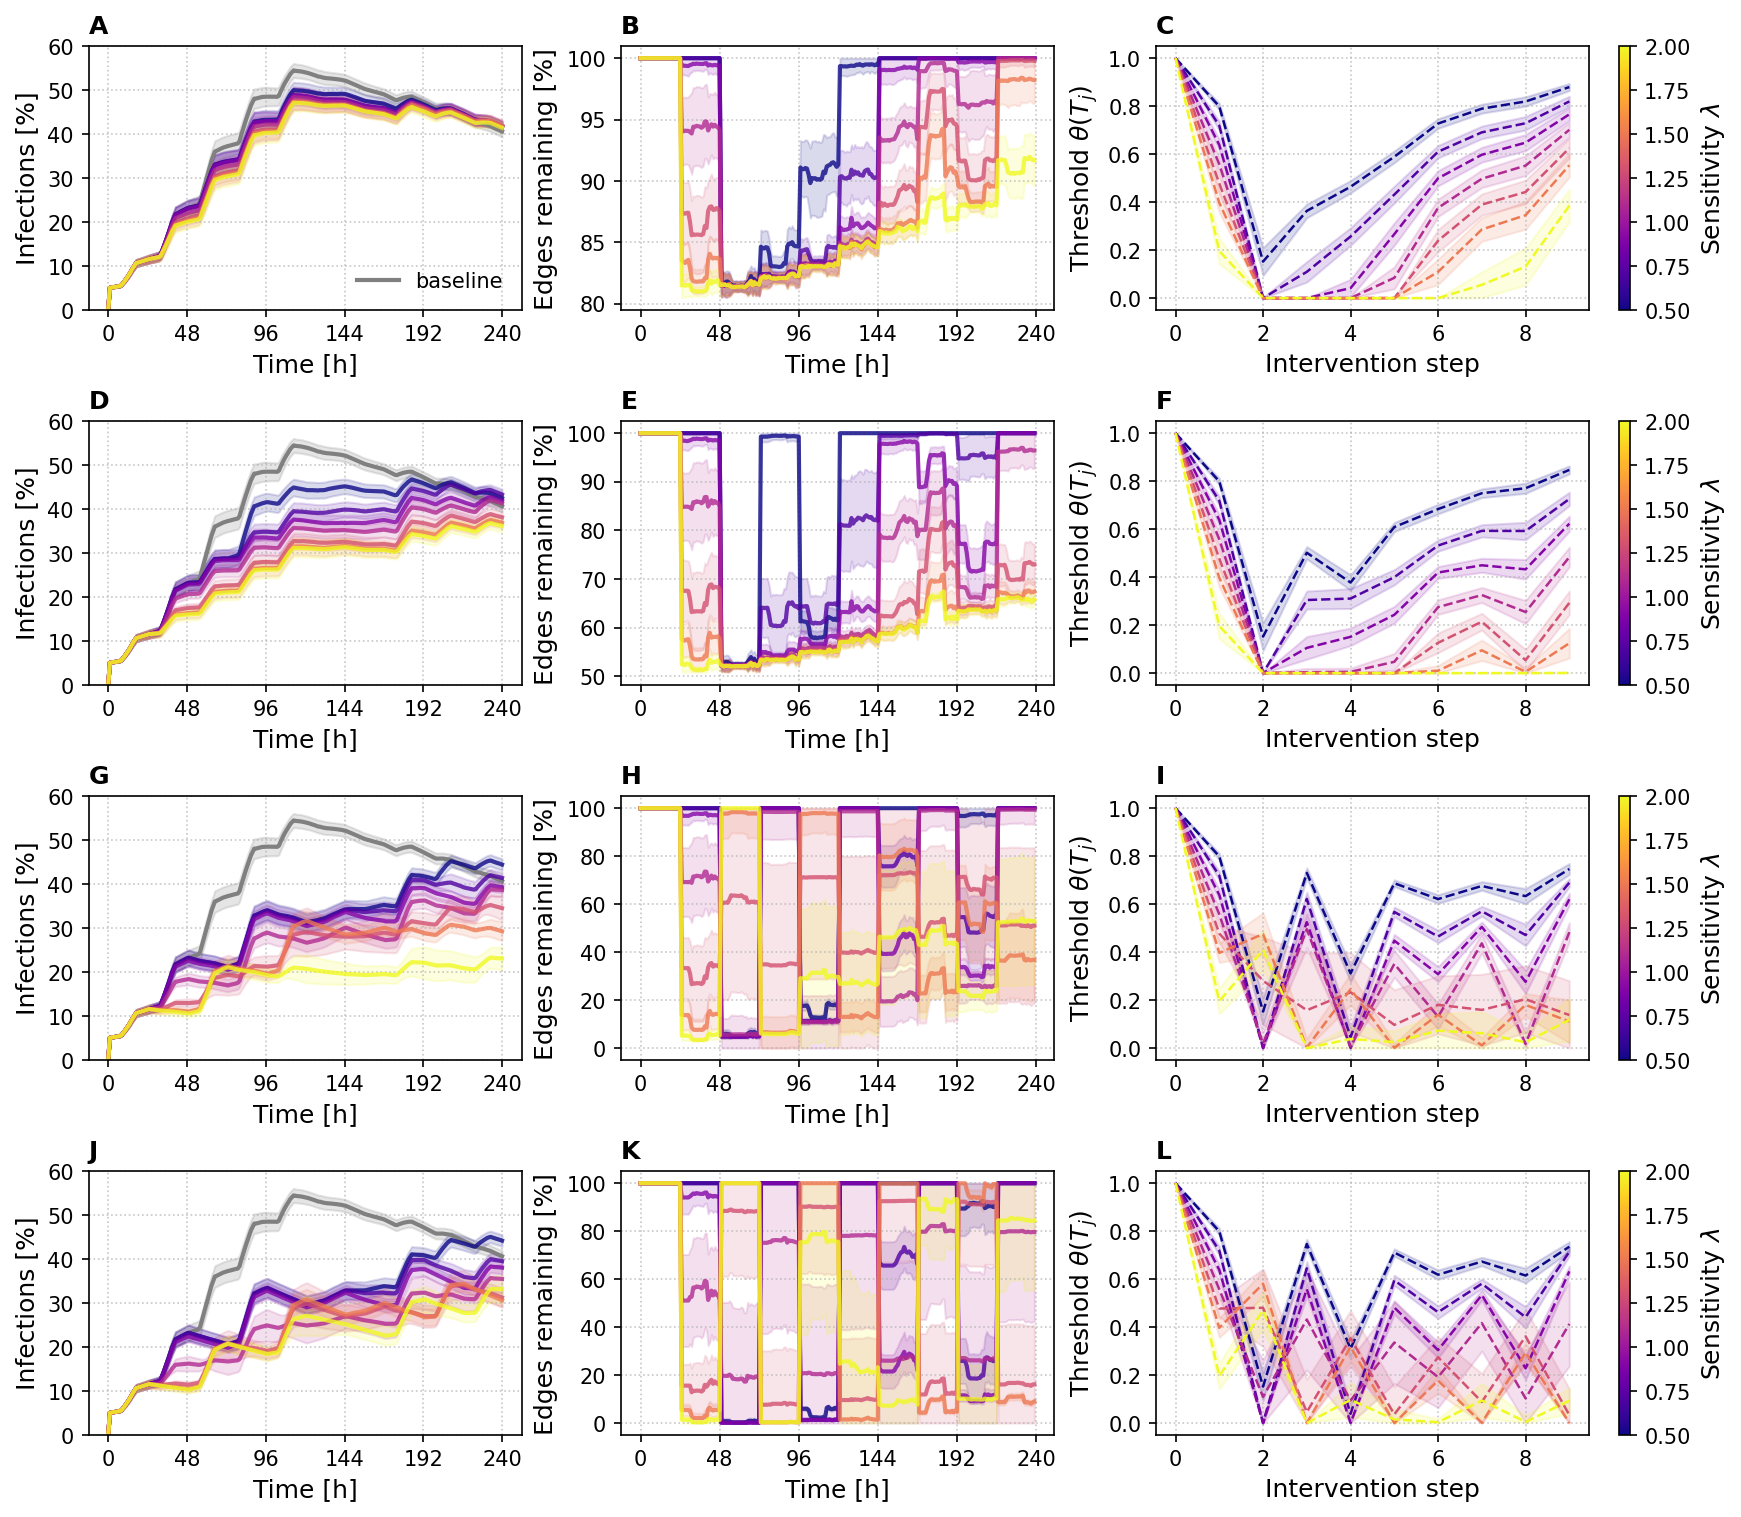

In [8]:
FILTER_DS = [0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 2.0]
ROW_CAPS  = [0.1, 0.25, 0.50,  1.00]

OUT_DIR = "../paper_figures"
# df_X, cache_X, summ_X must already be loaded for the dataset
fig_12panels_for_dataset(
    df       = df_abm,         # or df_dtu / df_office / df_abm30
    cache    = cache_abm,
    summ     = summ_abm,       # your summary dict used by edges/threshold panels
    outdir   = OUT_DIR,
    network_name = "abm",
    ds_list  = FILTER_DS,
    row_caps = ROW_CAPS,
    figsize  = (11.5, 10.0),
    axis_fs  = 12,
    tick_fs  = 10,
    cmap_name = "plasma"
)


✓ saved Fig_DTU_12panels.tif


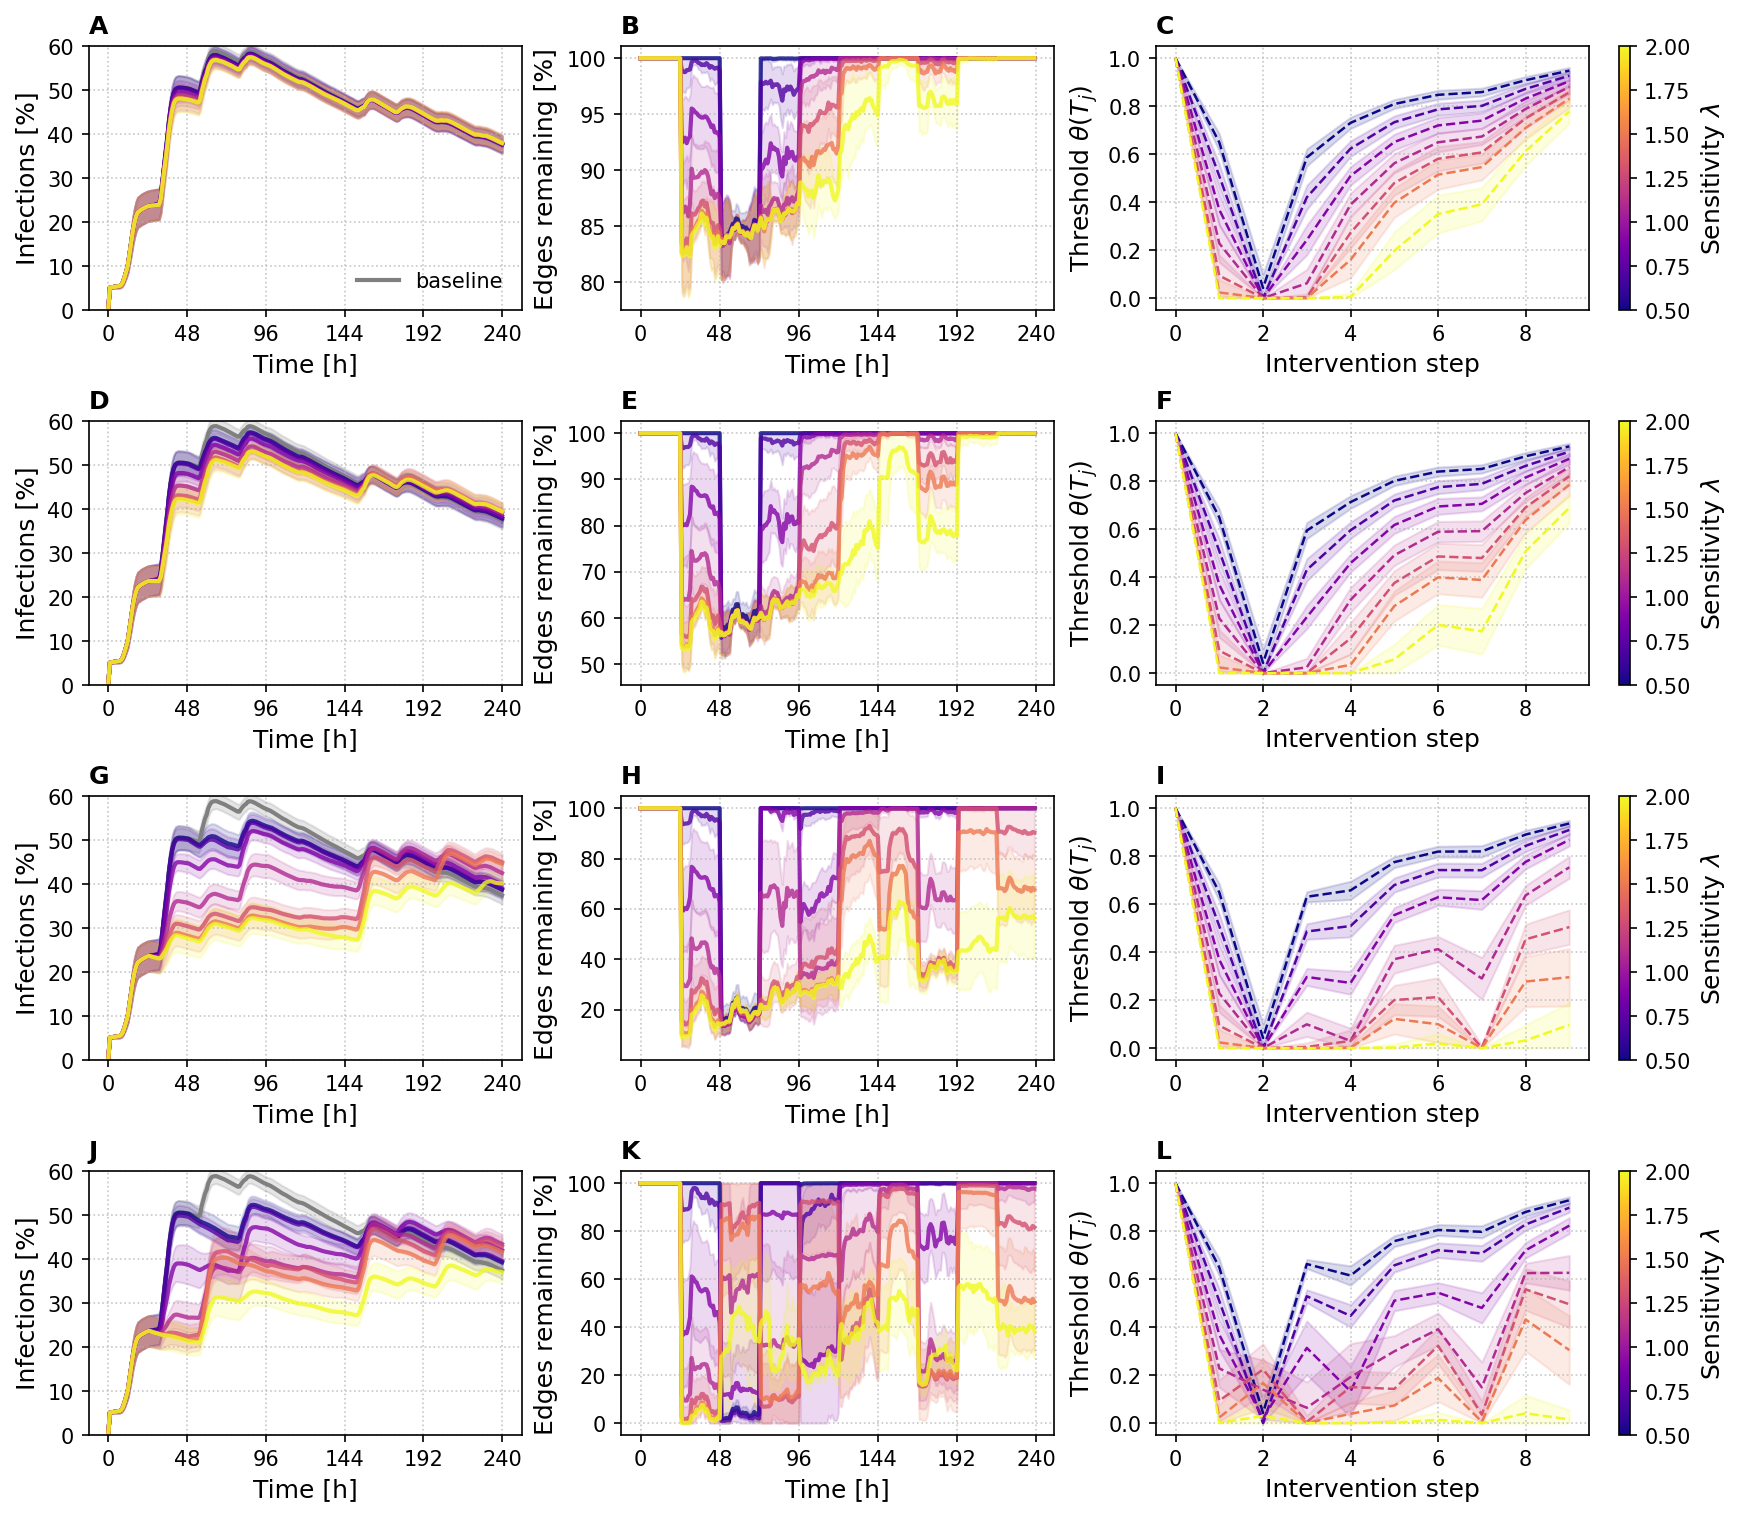

In [9]:
FILTER_DS = [0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 2.0]
ROW_CAPS  = [0.1, 0.25, 0.50,  1.00]

OUT_DIR = "../paper_figures"
# df_X, cache_X, summ_X must already be loaded for the dataset
fig_12panels_for_dataset(
    df       = df_dtu,         # or df_dtu / df_office / df_abm30
    cache    = cache_dtu,
    summ     = summ_dtu,       # your summary dict used by edges/threshold panels
    outdir   = OUT_DIR,
    network_name = "DTU",
    ds_list  = FILTER_DS,
    row_caps = ROW_CAPS,
    figsize  = (11.5, 10.0),
    axis_fs  = 12,
    tick_fs  = 10,
    cmap_name = "plasma"
)


✓ saved Fig_workplace_12panels.tif


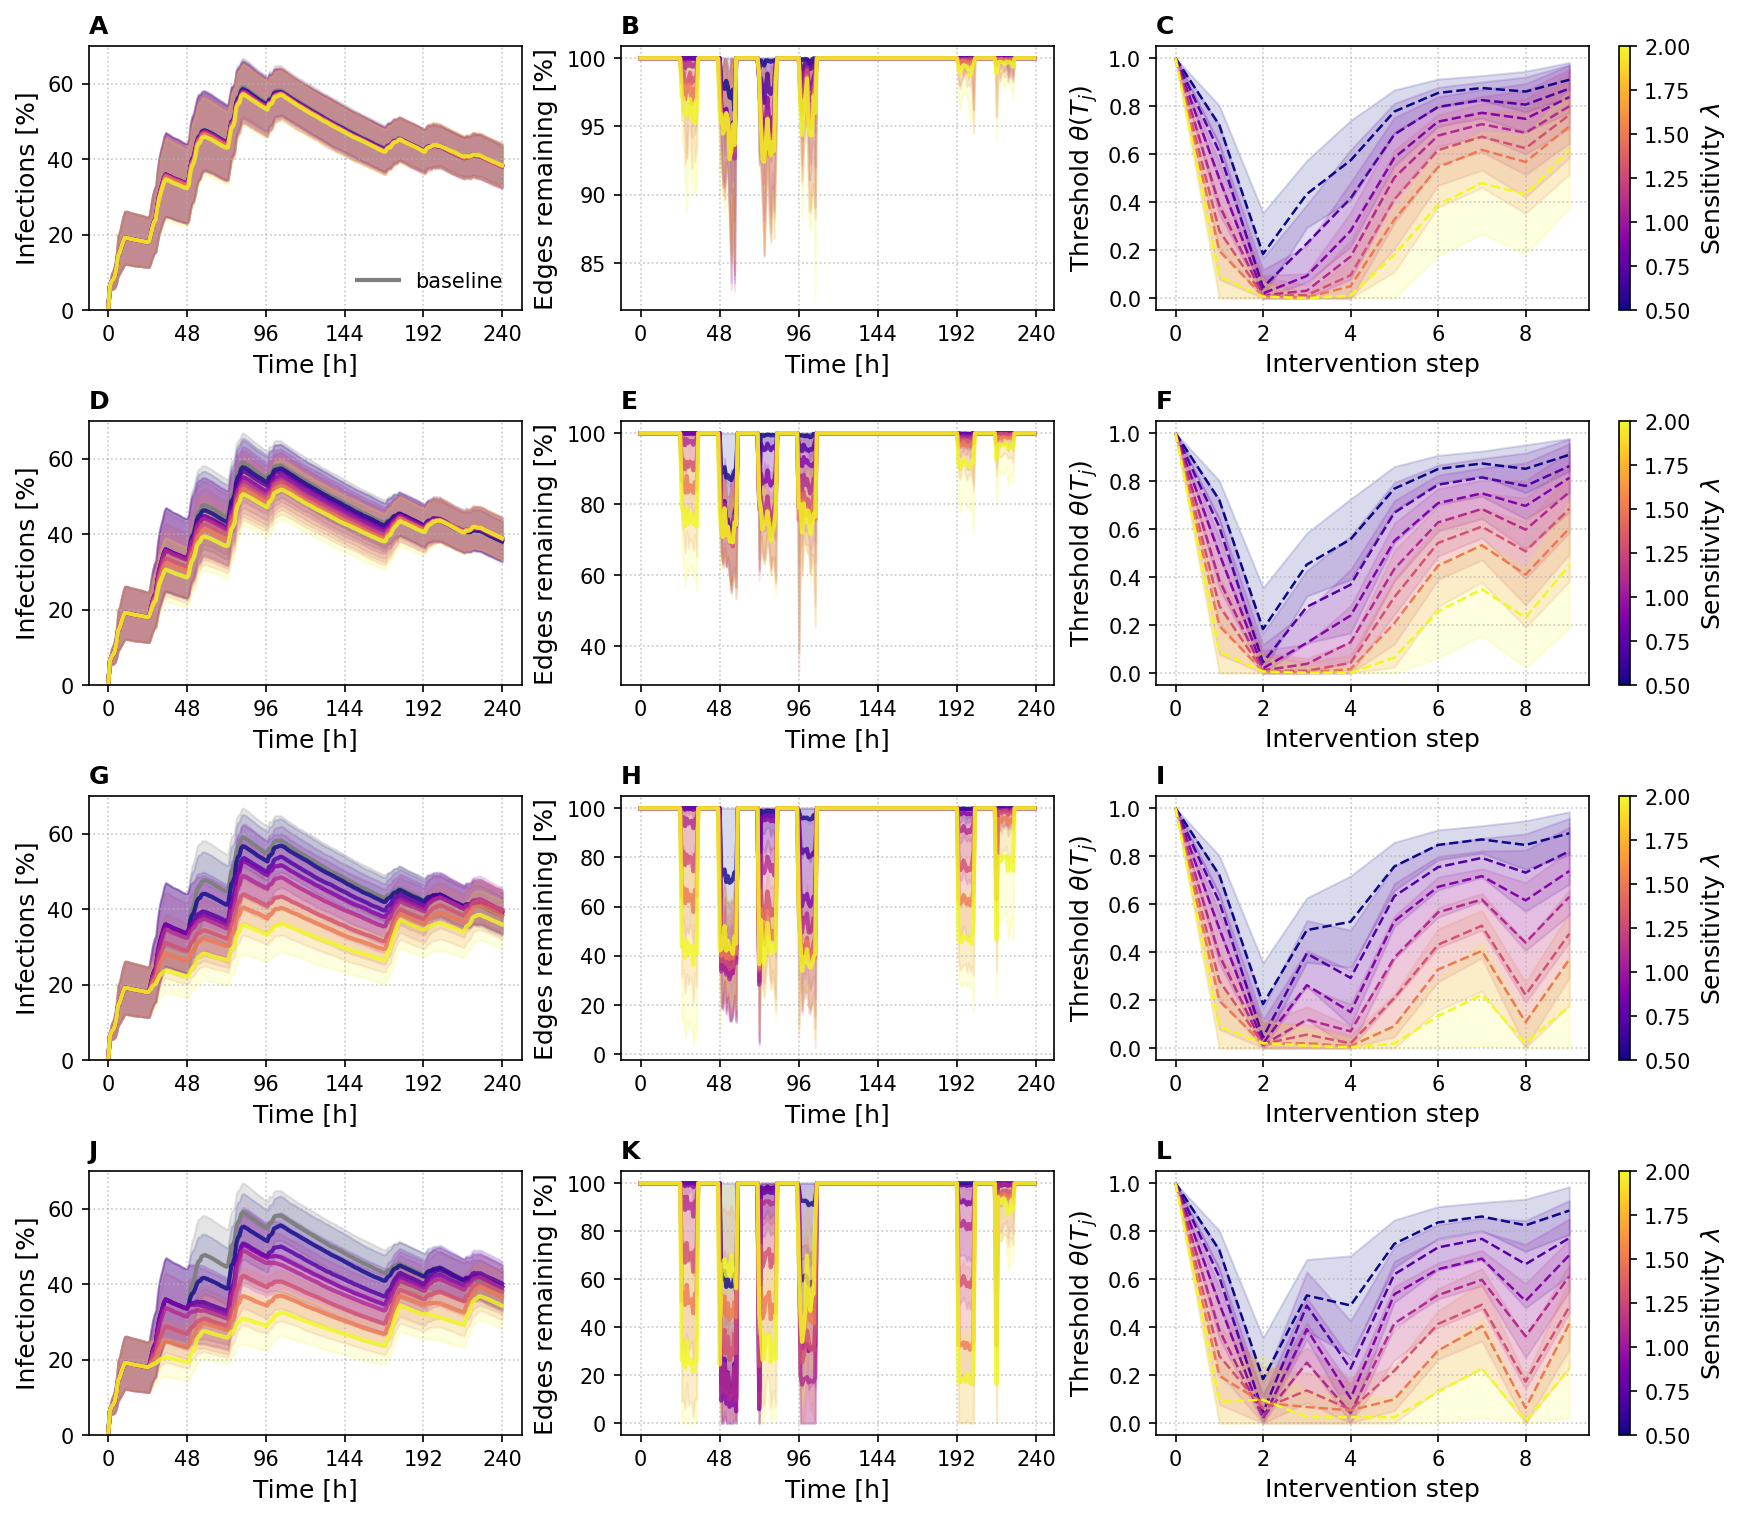

In [10]:
FILTER_DS = [0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 2.0]
ROW_CAPS  = [0.1, 0.25, 0.50,  1.00]

OUT_DIR = "../paper_figures"
# df_X, cache_X, summ_X must already be loaded for the dataset
fig_12panels_for_dataset(
    df       = df_office,         # or df_dtu / df_office / df_abm30
    cache    = cache_office,
    summ     = summ_office,       # your summary dict used by edges/threshold panels
    outdir   = OUT_DIR,
    network_name = "workplace",
    ds_list  = FILTER_DS,
    row_caps = ROW_CAPS,
    figsize  = (11.5, 10.0),
    axis_fs  = 12,
    tick_fs  = 10,
    cmap_name = "plasma"
)


Loading abm30 …
Loading 8 baseline + 0 risk-depth + 28 fixed-depth files
✓ results_without_ii24_ds100_mrfNA_fremNA_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p005_g0p002_BASELINE.zip (from cache)   (1/36)
✓ results_without_ii24_ds200_mrfNA_fremNA_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p005_g0p002_BASELINE.zip (from cache)   (2/36)
✓ results_without_ii24_ds70_mrfNA_fremNA_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p005_g0p002_BASELINE.zip (from cache)   (3/36)
✓ results_without_ii24_ds130_mrfNA_fremNA_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p005_g0p002_BASELINE.zip (from cache)   (4/36)
✓ results_without_ii24_ds110_mrfNA_fremNA_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p005_g0p002_BASELINE.zip (from cache)   (5/36)
✓ results_without_ii24_ds50_mrfNA_fremNA_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p005_g0p002_BASELINE.z

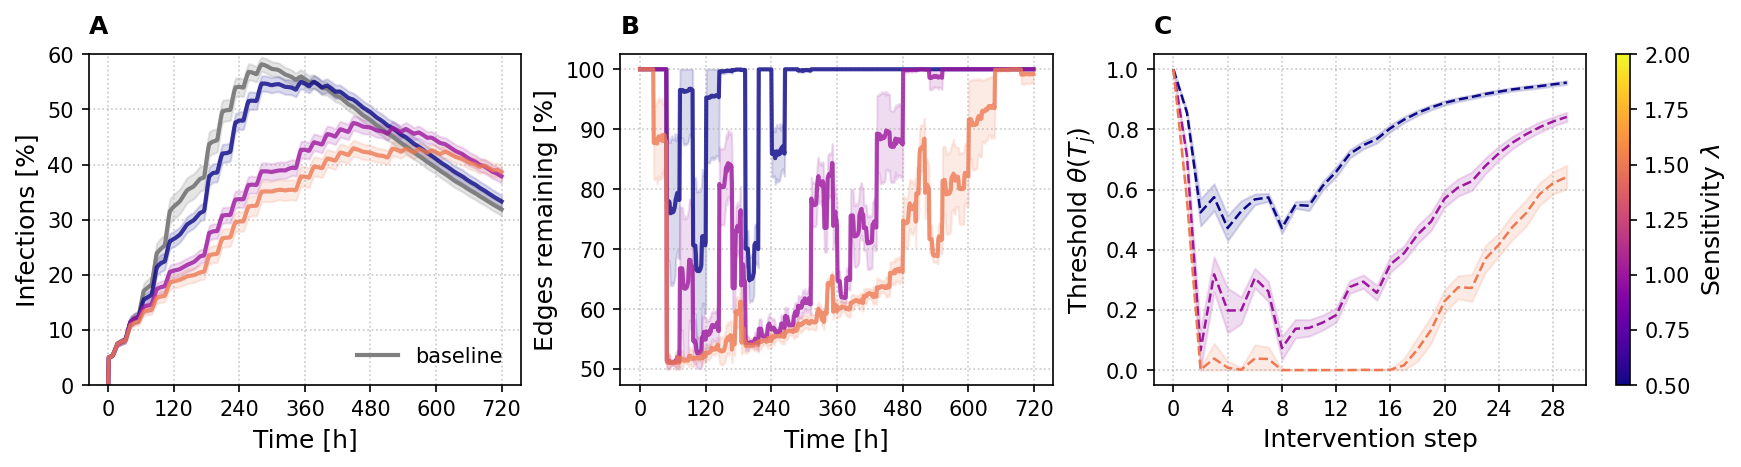

In [11]:
FILTER_DS = [0.5, 1.0, 1.5, 2.0]
ROW_CAPS  = [0.25]

df_abm30,   cache_abm30   = load_dataset("abm30")
summ_abm30 = collect_summaries(df_abm30,   cache_abm30)

OUT_DIR = "../paper_figures"
# df_X, cache_X, summ_X must already be loaded for the dataset
fig_12panels_for_dataset(
    df       = df_abm30,         # or df_dtu / df_office / df_abm30
    cache    = cache_abm30,
    summ     = summ_abm30,       # your summary dict used by edges/threshold panels
    outdir   = OUT_DIR,
    network_name = "abm30",
    ds_list  = FILTER_DS,
    row_caps = ROW_CAPS,
    figsize  = (11.5, 3.0),
    axis_fs  = 12,
    tick_fs  = 10,
    cmap_name = "plasma"
)

